# Automatic License Plate Detection

The project's main objective is to develop a robust and efficient automatic license plate detection system that can operate in real-time, providing valuable insights and solutions in transportation, security, and urban management. This can ultimately contribute to smarter cities and improved vehicle monitoring systems.

- Dataset: The dataset has been obtained from kaggle. The dataset contains images and their respective xml files.







Data saved to license_plate_data.csv


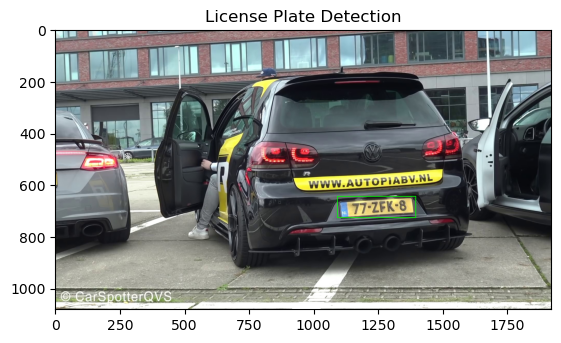

In [4]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
from PIL import Image

# Path to the folder containing images and XML files
data_folder = r'C:\Users\irosh\Downloads\Automatic-License-Plate-Detection-main\Automatic-License-Plate-Detection-main\images'

# Lists to store data
image_data = []
columns = ['image_name', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']

# Loop through all files in the folder
for filename in os.listdir(data_folder):
    if filename.endswith('.xml'):
        # Parse XML file
        xml_path = os.path.join(data_folder, filename)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Get image file name
        image_name = root.find('filename').text

        # Get size information
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        # Get object (license plate) bounding box details
        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Append the data to the list
            image_data.append([image_name, width, height, xmin, ymin, xmax, ymax])

# Convert to DataFrame
df = pd.DataFrame(image_data, columns=columns)

# Save to CSV
csv_output_path = 'license_plate_data.csv'
df.to_csv(csv_output_path, index=False)

print(f"Data saved to {csv_output_path}")

# (Optional) To visualize one of the images with bounding box
import matplotlib.pyplot as plt
import cv2

# Choose an image to visualize
sample_image_name = df.iloc[0]['image_name']
image_path = os.path.join(data_folder, sample_image_name)

# Read and display the image with bounding box
image = cv2.imread(image_path)
xmin, ymin, xmax, ymax = df.iloc[0][['xmin', 'ymin', 'xmax', 'ymax']]

# Draw bounding box
cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

# Convert BGR image to RGB for displaying
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show the image with bounding box
plt.imshow(image_rgb)
plt.title('License Plate Detection')
plt.show()


This code effectively automates the process of extracting license plate information from XML annotations associated with images. The extracted data is structured into a CSV file for easy access and future processing. Additionally, it provides a visualization of the detection results, allowing to confirm that the license plates are correctly identified and annotated in the images. This kind of preprocessing is crucial for training machine learning models in computer vision tasks.








## Single Shot MultiBox Detector (SSD)

The Single Shot MultiBox Detector (SSD) is a popular deep learning model used for object detection in real-time. SSD is particularly well-suited for detecting objects within an image and predicting the bounding box coordinates as well as the class label for each object. 

SSD is an object detection model that operates in a single pass, meaning it does not need to propose regions of interest (RoIs) separately like other models (such as Faster R-CNN). This makes SSD highly efficient for real-time detection tasks. SSD generates a fixed number of bounding boxes and class predictions directly from feature maps produced by the backbone network.


### SSD Architecture:
- **Base Network (e.g., VGG16 or MobileNet):** Extracts features from the input image.
- **Additional Convolutional Layers:** Produce feature maps at different resolutions.
- **Predictions from Multiple Feature Maps:** Predictions are made from multiple scales for bounding boxes and class labels.

In [16]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [18]:
# Load CSV data
df = pd.read_csv('license_plate_data.csv')

# Function to load and preprocess images
def load_image_and_boxes(image_name):
    image_path = os.path.join(data_folder, image_name)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (300, 300))  # Resize to SSD input size
    image = image / 255.0  # Normalize pixel values
    return image

# Prepare training data
images = []
boxes = []

for index, row in df.iterrows():
    image = load_image_and_boxes(row['image_name'])
    images.append(image)

    # Convert bounding box to [center_x, center_y, width, height]
    width, height = row['width'], row['height']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    box = [
        (xmin + xmax) / 2 / width,  # center_x
        (ymin + ymax) / 2 / height,  # center_y
        (xmax - xmin) / width,        # width
        (ymax - ymin) / height         # height
    ]
    boxes.append(box)

images = np.array(images)
boxes = np.array(boxes)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, boxes, test_size=0.2, random_state=42)


The above code prepares the data required for training an SSD model for license plate detection. It loads the images and their associated bounding boxes, normalizes the images, and formats the bounding box coordinates appropriately. Finally, it splits the data into training and validation sets, which is essential for assessing the model's performance during training.








The code below sets up an SSD model for license plate detection by utilizing MobileNetV2 as the backbone feature extractor. The model is designed to predict bounding box coordinates for detected objects. By freezing the base model's layers, it leverages pre-trained features while allowing for the addition of custom layers tailored to the specific task. The model is then compiled with an optimizer and a loss function suitable for bounding box regression.


- MobileNetV2 is a cnn model, which can be used for transfer learning. Its lightweight architecture and pre-trained models make it an excellent choice for fine-tuning on specific tasks or datasets, particularly when computational resources are limited or real-time processing is required.





In [20]:
# Load a pre-trained SSD model (e.g., SSD MobileNet)
base_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3), include_top=False)

# Freeze the base model layers
base_model.trainable = False

# Add SSD layers
inputs = layers.Input(shape=(300, 300, 3))
x = base_model(inputs, training=False)

# Add additional layers
x = layers.Conv2D(4, (1, 1), padding='same')(x)  # For bounding box predictions
x = layers.Flatten()(x)
outputs = layers.Dense(4)(x)  # Final layer for bounding boxes

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\irosh\AppData\Local\Temp\ipykernel_25968\3646118682.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3), include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
# Define a callback to save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("ssd_license_plate_model.keras", save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16, callbacks=[checkpoint_cb])


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 739ms/step - loss: 2.8895 - val_loss: 2.1092
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 615ms/step - loss: 1.1757 - val_loss: 1.5497
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 580ms/step - loss: 0.6184 - val_loss: 1.3606
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 508ms/step - loss: 0.3868 - val_loss: 1.1900
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 525ms/step - loss: 0.2323 - val_loss: 1.1353
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 517ms/step - loss: 0.1603 - val_loss: 1.0928
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 551ms/step - loss: 0.1031 - val_loss: 1.0750
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 546ms/step - loss: 0.0690 - val_loss: 1.0614
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 509ms/step - loss: 0.0441 - val_loss: 1.0533
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 520ms/step - loss: 0.0297 - val_loss: 1.0486
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 513ms/step - loss: 0.0216 - val_loss: 1.0486
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 522ms/ste

The code above sets up a model checkpoint callback to save the best-performing model during training and then trains the SSD model using the training data while validating against a separate validation set. The training process is monitored for improvements, and the best model (in terms of validation performance) is saved for future use, allowing for effective management of model training and evaluation.

In [26]:
# Evaluate the model
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - loss: 1.0468
Validation Loss: 1.0518440008163452


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Box for Sample 0: [ 1.0703315   1.549781    0.44689983 -0.4080726 ]


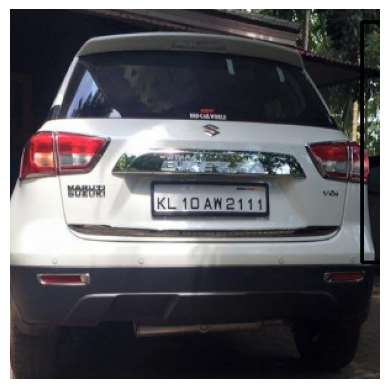

In [36]:
def visualize_predictions(image, predicted_box):
   
    height, width = image.shape[:2]

    # Calculate bounding box from predicted box (center_x, center_y, width, height)
    xmin = int((predicted_box[0] * width) - (predicted_box[2] * width) / 2)
    ymin = int((predicted_box[1] * height) - (predicted_box[3] * height) / 2)
    xmax = int((predicted_box[0] * width) + (predicted_box[2] * width) / 2)
    ymax = int((predicted_box[1] * height) + (predicted_box[3] * height) / 2)

    # Convert the image back to uint8
    image_uint8 = (image * 255).astype(np.uint8)

    # Draw the bounding box
    cv2.rectangle(image_uint8, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    # Display the image with bounding box
    plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Test visualization on a validation sample
sample_index = 0
sample_image = X_val[sample_index]
predicted_box = model.predict(sample_image[np.newaxis, ...])[0]

# Print the predicted bounding box
print(f"Predicted Box for Sample {sample_index}: {predicted_box}")

visualize_predictions(sample_image, predicted_box)


## Feedforward neural network

 A simple feedforward neural network (also known as a fully connected neural network or dense neural network) is defined and trained to predict bounding box coordinates for license plates. This model is a straightforward fully connected neural network designed for regression tasks, specifically for predicting bounding box coordinates from images.

In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Flatten(input_shape=(300, 300, 3)),  # Flatten the image
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4)  # Output layer for bounding box coordinates
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)


C:\Users\irosh\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 3544.3748 - val_loss: 970.6440
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 577.5112 - val_loss: 380.6370
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 304.2809 - val_loss: 80.0319
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 127.2340 - val_loss: 88.8926
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 59.9735 - val_loss: 63.8050
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - loss: 37.6169 - val_loss: 31.8923
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 19.7648 - val_loss: 26.9623
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - loss: 9.9084 - val_loss: 17.2115
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - loss: 6.7150 - val_loss: 13.9158
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - loss: 4.9749 - val_loss: 10.4057


The code above sets up a basic feedforward neural network to predict bounding box coordinates for license plates from input images. The model uses two hidden layers with ReLU activations to learn the complex mappings between the images and their corresponding bounding boxes, and it trains using the Adam optimizer with mean squared error loss for regression. After training, the model can be used to predict bounding boxes for new images.








2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean Absolute Error (MAE): 1.7247877892981869
Mean IoU: 0.0


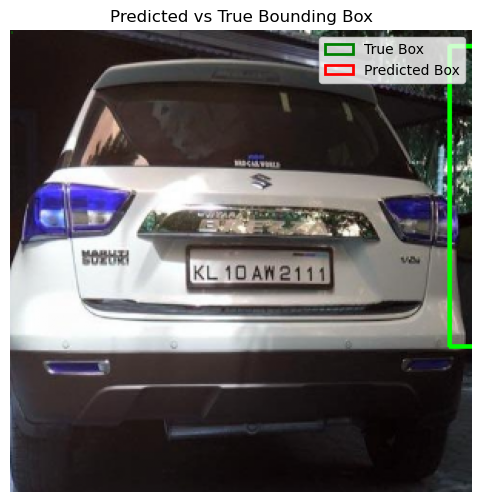

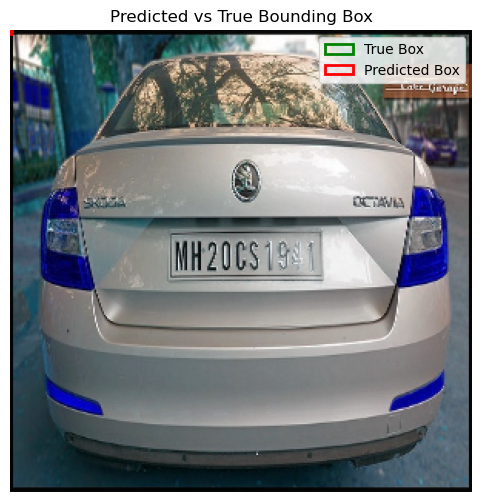

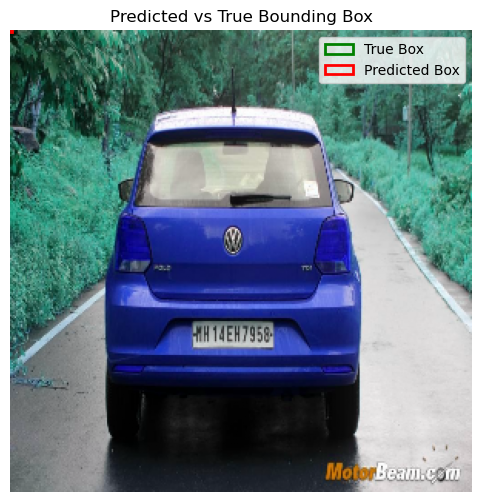

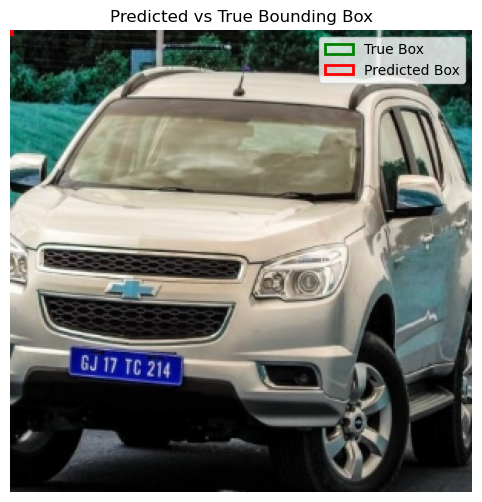

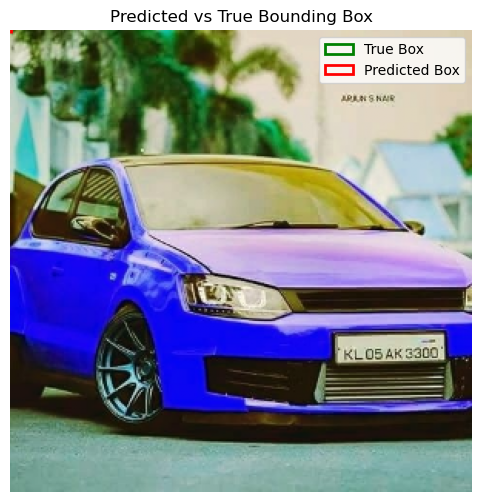

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the validation set
predictions = model.predict(X_val)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(predictions - y_val))
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Intersection over Union (IoU)
def calculate_iou(boxA, boxB):
    # Calculate intersection coordinates
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Calculate the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Calculate the area of both boxes
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    # Calculate the Intersection over Union (IoU)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Calculate IoU for all predictions
ious = []
for pred, true in zip(predictions, y_val):
    # Convert back to [xmin, ymin, xmax, ymax]
    pred_box = [
        pred[0] - (pred[2] / 2),  # xmin
        pred[1] - (pred[3] / 2),  # ymin
        pred[0] + (pred[2] / 2),  # xmax
        pred[1] + (pred[3] / 2)   # ymax
    ]
    true_box = [
        true[0] - (true[2] / 2),  # xmin
        true[1] - (true[3] / 2),  # ymin
        true[0] + (true[2] / 2),  # xmax
        true[1] + (true[3] / 2)   # ymax
    ]
    
    ious.append(calculate_iou(pred_box, true_box))

mean_iou = np.mean(ious)
print(f'Mean IoU: {mean_iou}')

# Visualize some predictions
for i in range(5):  # Show first 5 predictions
    sample_image = X_val[i]
    pred_box = predictions[i]
    true_box = y_val[i]
    
    # Draw the bounding boxes
    plt.figure(figsize=(8, 6))
    plt.imshow(sample_image)
    
    # True box
    plt.gca().add_patch(plt.Rectangle(
        (true_box[0] - true_box[2] / 2, true_box[1] - true_box[3] / 2), 
        true_box[2], true_box[3], fill=False, edgecolor='green', linewidth=2, label='True Box'))
    
    # Predicted box
    plt.gca().add_patch(plt.Rectangle(
        (pred_box[0] - pred_box[2] / 2, pred_box[1] - pred_box[3] / 2), 
        pred_box[2], pred_box[3], fill=False, edgecolor='red', linewidth=2, label='Predicted Box'))

    plt.title('Predicted vs True Bounding Box')
    plt.legend()
    plt.axis('off')
    plt.show()


In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4)  # Output layer for bounding box coordinates
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)


C:\Users\irosh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 865ms/step - loss: 25.0514 - val_loss: 0.2675
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 932ms/step - loss: 0.1369 - val_loss: 0.2452
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 901ms/step - loss: 0.0534 - val_loss: 0.2238
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 942ms/step - loss: 0.0316 - val_loss: 0.2144
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 934ms/step - loss: 0.0256 - val_loss: 0.2274
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 858ms/step - loss: 0.0189 - val_loss: 0.1882
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0164 - val_loss: 0.2058
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0179 - val_loss: 0.1971
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 786ms/step - loss: 0.0143 - val_loss: 0.2315
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 823ms/step - loss: 0.0119 - val_loss: 0.2408
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 880ms/step - loss: 0.0128 - val_loss: 0.2774
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 869ms/step - loss: 0.0106 - val_loss: 0

The code above implements a convolutional neural network (CNN) to predict bounding box coordinates for license plates in images. The model consists of multiple convolutional and pooling layers to extract features from the input images, followed by dense layers to make the final predictions. The use of convolutional layers allows the model to learn spatial hierarchies of features, making it well-suited for image-related tasks. The model is trained using mean squared error loss to minimize the error in the predicted bounding box coordinates.








1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/stepWARNING:tensorflow:5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002BDF071EFC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
Mean Absolute Error (MAE): 0.15237090088254499
Mean IoU: 0.5165407669219066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


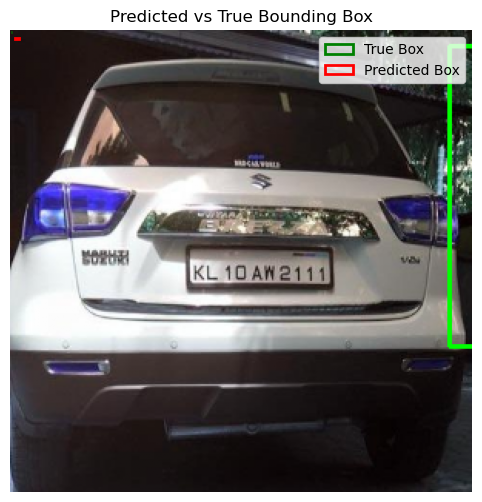

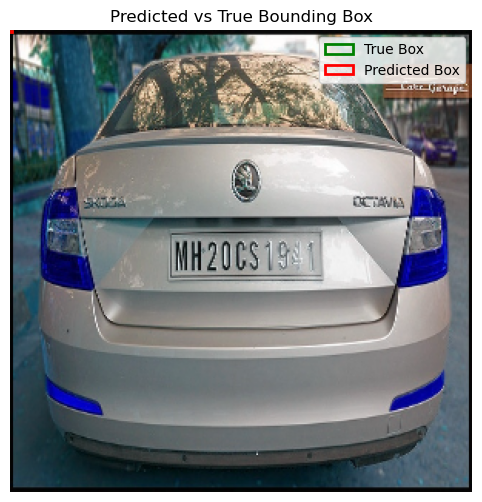

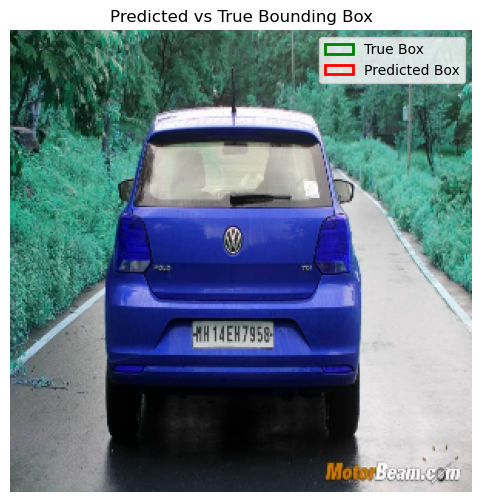

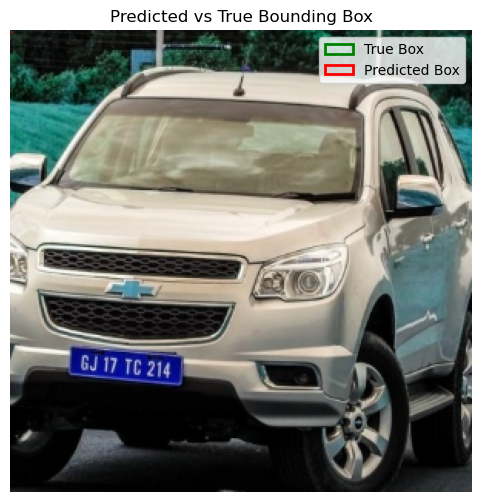

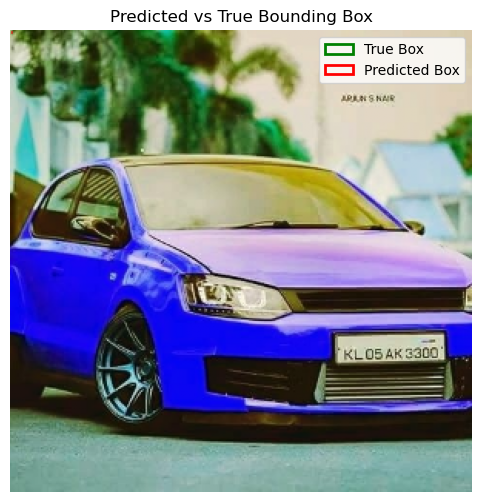

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the validation set
predictions = model.predict(X_val)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(predictions - y_val))
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Intersection over Union (IoU)
def calculate_iou(boxA, boxB):
    # Calculate intersection coordinates
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Calculate the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Calculate the area of both boxes
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    # Calculate the Intersection over Union (IoU)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Calculate IoU for all predictions
ious = []
for pred, true in zip(predictions, y_val):
    # Convert back to [xmin, ymin, xmax, ymax]
    pred_box = [
        pred[0] - (pred[2] / 2),  # xmin
        pred[1] - (pred[3] / 2),  # ymin
        pred[0] + (pred[2] / 2),  # xmax
        pred[1] + (pred[3] / 2)   # ymax
    ]
    true_box = [
        true[0] - (true[2] / 2),  # xmin
        true[1] - (true[3] / 2),  # ymin
        true[0] + (true[2] / 2),  # xmax
        true[1] + (true[3] / 2)   # ymax
    ]
    
    ious.append(calculate_iou(pred_box, true_box))

mean_iou = np.mean(ious)
print(f'Mean IoU: {mean_iou}')

# Visualize some predictions
for i in range(5):  # Show first 5 predictions
    sample_image = X_val[i]
    pred_box = predictions[i]
    true_box = y_val[i]
    
    # Draw the bounding boxes
    plt.figure(figsize=(8, 6))
    plt.imshow(sample_image)
    
    # True box
    plt.gca().add_patch(plt.Rectangle(
        (true_box[0] - true_box[2] / 2, true_box[1] - true_box[3] / 2), 
        true_box[2], true_box[3], fill=False, edgecolor='green', linewidth=2, label='True Box'))
    
    # Predicted box
    plt.gca().add_patch(plt.Rectangle(
        (pred_box[0] - pred_box[2] / 2, pred_box[1] - pred_box[3] / 2), 
        pred_box[2], pred_box[3], fill=False, edgecolor='red', linewidth=2, label='Predicted Box'))

    plt.title('Predicted vs True Bounding Box')
    plt.legend()
    plt.axis('off')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


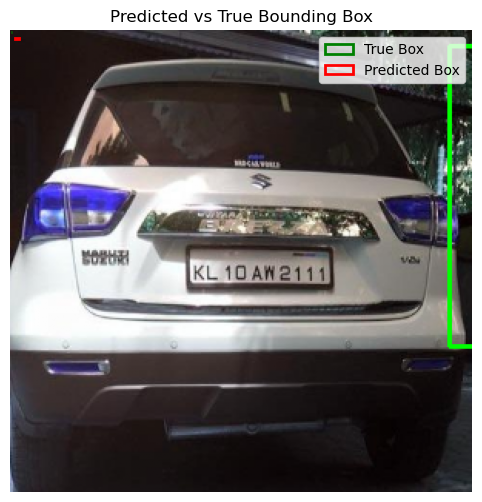

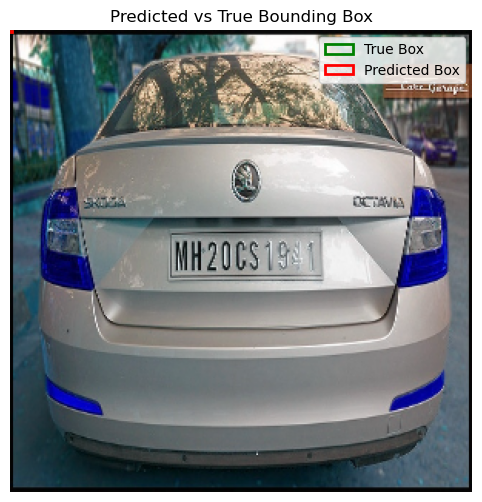

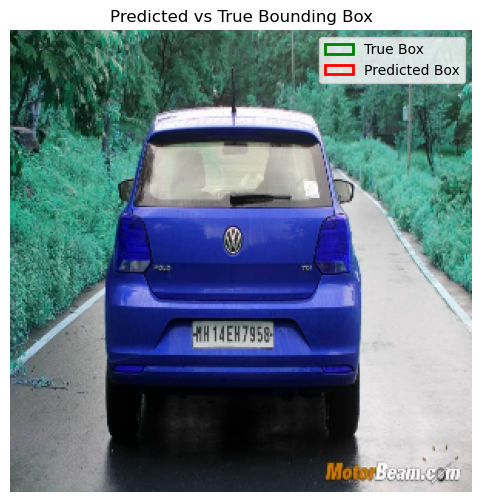

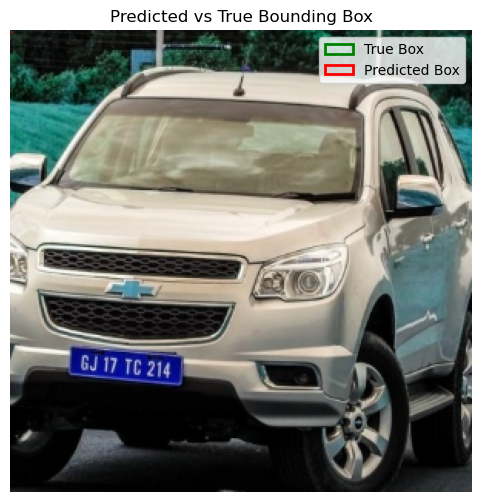

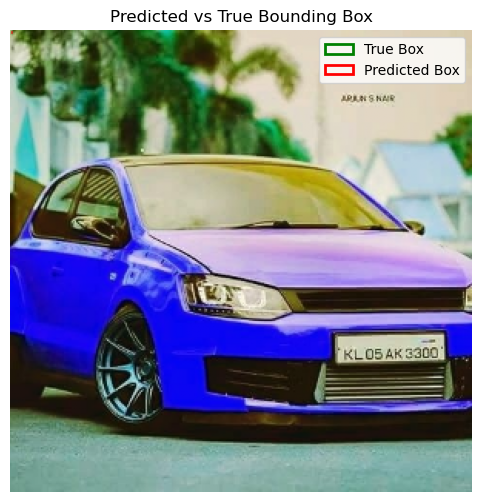

In [61]:
# Visualize some predictions
def visualize_predictions(images, predictions, true_boxes, num_images=5):
    for i in range(num_images):  # Show first 5 predictions
        sample_image = images[i]
        pred_box = predictions[i]
        true_box = true_boxes[i]
        
        # Draw the bounding boxes
        plt.figure(figsize=(8, 6))
        plt.imshow(sample_image)
        
        # True box
        plt.gca().add_patch(plt.Rectangle(
            (true_box[0] - true_box[2] / 2, true_box[1] - true_box[3] / 2), 
            true_box[2], true_box[3], fill=False, edgecolor='green', linewidth=2, label='True Box'))
        
        # Predicted box
        plt.gca().add_patch(plt.Rectangle(
            (pred_box[0] - pred_box[2] / 2, pred_box[1] - pred_box[3] / 2), 
            pred_box[2], pred_box[3], fill=False, edgecolor='red', linewidth=2, label='Predicted Box'))

        plt.title('Predicted vs True Bounding Box')
        plt.legend()
        plt.axis('off')
        plt.show()

# Call the function to visualize predictions
visualize_predictions(X_val, predictions, y_val, num_images=5)


## Haar Cascade

The Haar Cascade Classifier is a popular and traditional object detection algorithm primarily used for detecting objects in images and video streams.Haar Cascade uses Haar-like features to detect objects in images. These features are simple rectangular filters that are applied to the image at different scales and positions to capture patterns like edges, textures, and more. The algorithm then evaluates these features using an efficient method called the integral image. Haar Cascade works in a multi-stage approach, where each stage applies a series of classifiers (weak learners) that either pass or reject regions of the image based on whether they contain the object of interest.

- Pre-Trained Classifiers: OpenCV provides several pre-trained Haar Cascade classifiers, such as for face detection, eye detection, and license plate detection, eliminating the need to train models from scratch for common tasks.
 

 

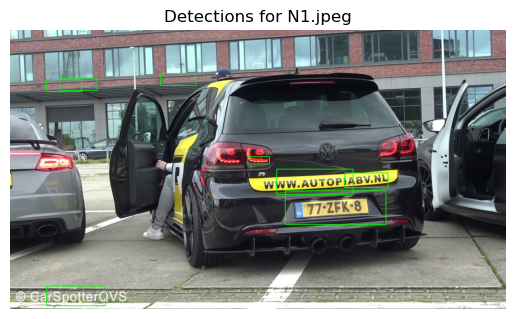

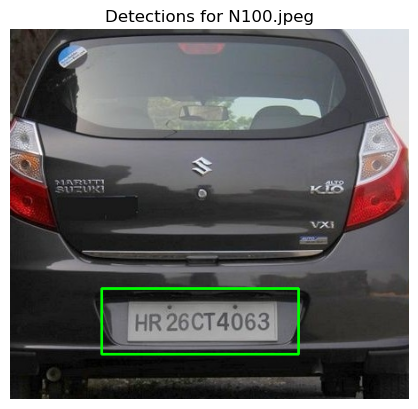

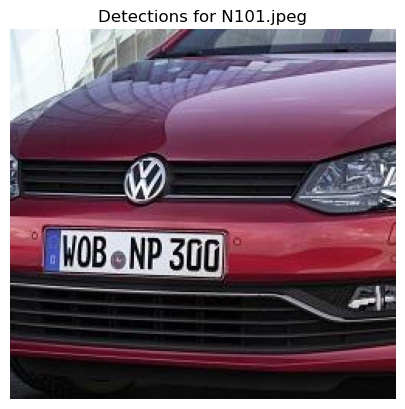

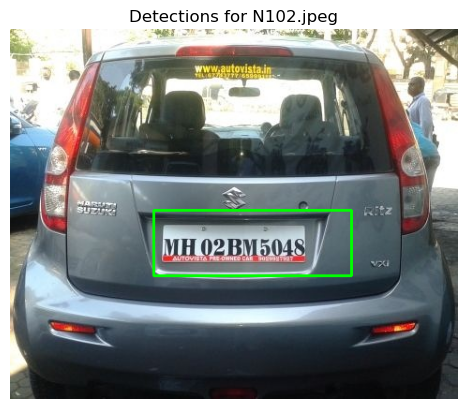

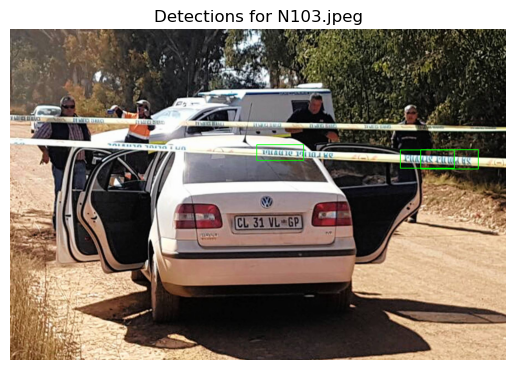

In [82]:
import cv2
import os
import matplotlib.pyplot as plt

# Load the Haar Cascade for license plate detection
plate_cascade = cv2.CascadeClassifier(r"C:\Users\irosh\Downloads\haarcascade_russian_plate_number.xml")

# Check if the classifier was loaded correctly
if plate_cascade.empty():
    print("Error loading cascade classifier. Please check the path.")
else:
    # Path to image folder
    data_folder = r'C:\Users\irosh\Downloads\Automatic-License-Plate-Detection-main\Automatic-License-Plate-Detection-main\images'

    # Initialize a counter to limit the number of outputs
    output_limit = 5  # Set the maximum number of images to display
    count = 0  # Initialize a counter for displayed images

    # Loop through images in the folder and run detection
    for filename in os.listdir(data_folder):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(data_folder, filename)
            
            # Load the image
            img = cv2.imread(image_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

            # Detect license plates
            plates = plate_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

            # Draw bounding boxes around detected plates
            for (x, y, w, h) in plates:
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Show the image with detected plates
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f'Detections for {filename}')
            plt.show()

            # Increment the counter and check if the limit is reached
            count += 1
            if count >= output_limit:
                break  # Exit the loop if the output limit is reached


The code above effectively loads images from a specified folder, detects license plates using a Haar Cascade classifier, and visualizes the detections by drawing bounding boxes around the plates. It limits the output to a defined number of images, making it a useful tool for quickly assessing the performance of the detection algorithm on a dataset of images.